In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics



In [2]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

### Custom pipeline for dat pre-processing

In [3]:
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = True):
        self.label_encode = label_encode
        self.process_label = process_label
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label:
            def label_transformer(category):
                if category == 'Normal':
                    return 0
                elif category in ['Reconnaissance', 'Analysis', 'Fuzzers', 'Shellcode', 'Generic']:
                    return 0
                elif category in ['Backdoor', 'DoS', 'Exploits', 'Worms']:
                    return 1

            df['label'] = df['attack_cat'].apply(label_transformer)
            df.drop('attack_cat', axis=1, inplace=True)

        return df

In [4]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [5]:
pipeline = PreProcessPipeline(label_encode=True, process_label=True)

# Transform both training and test data
train_df = pipeline.transform(train_df)
test_df = pipeline.transform(test_df)

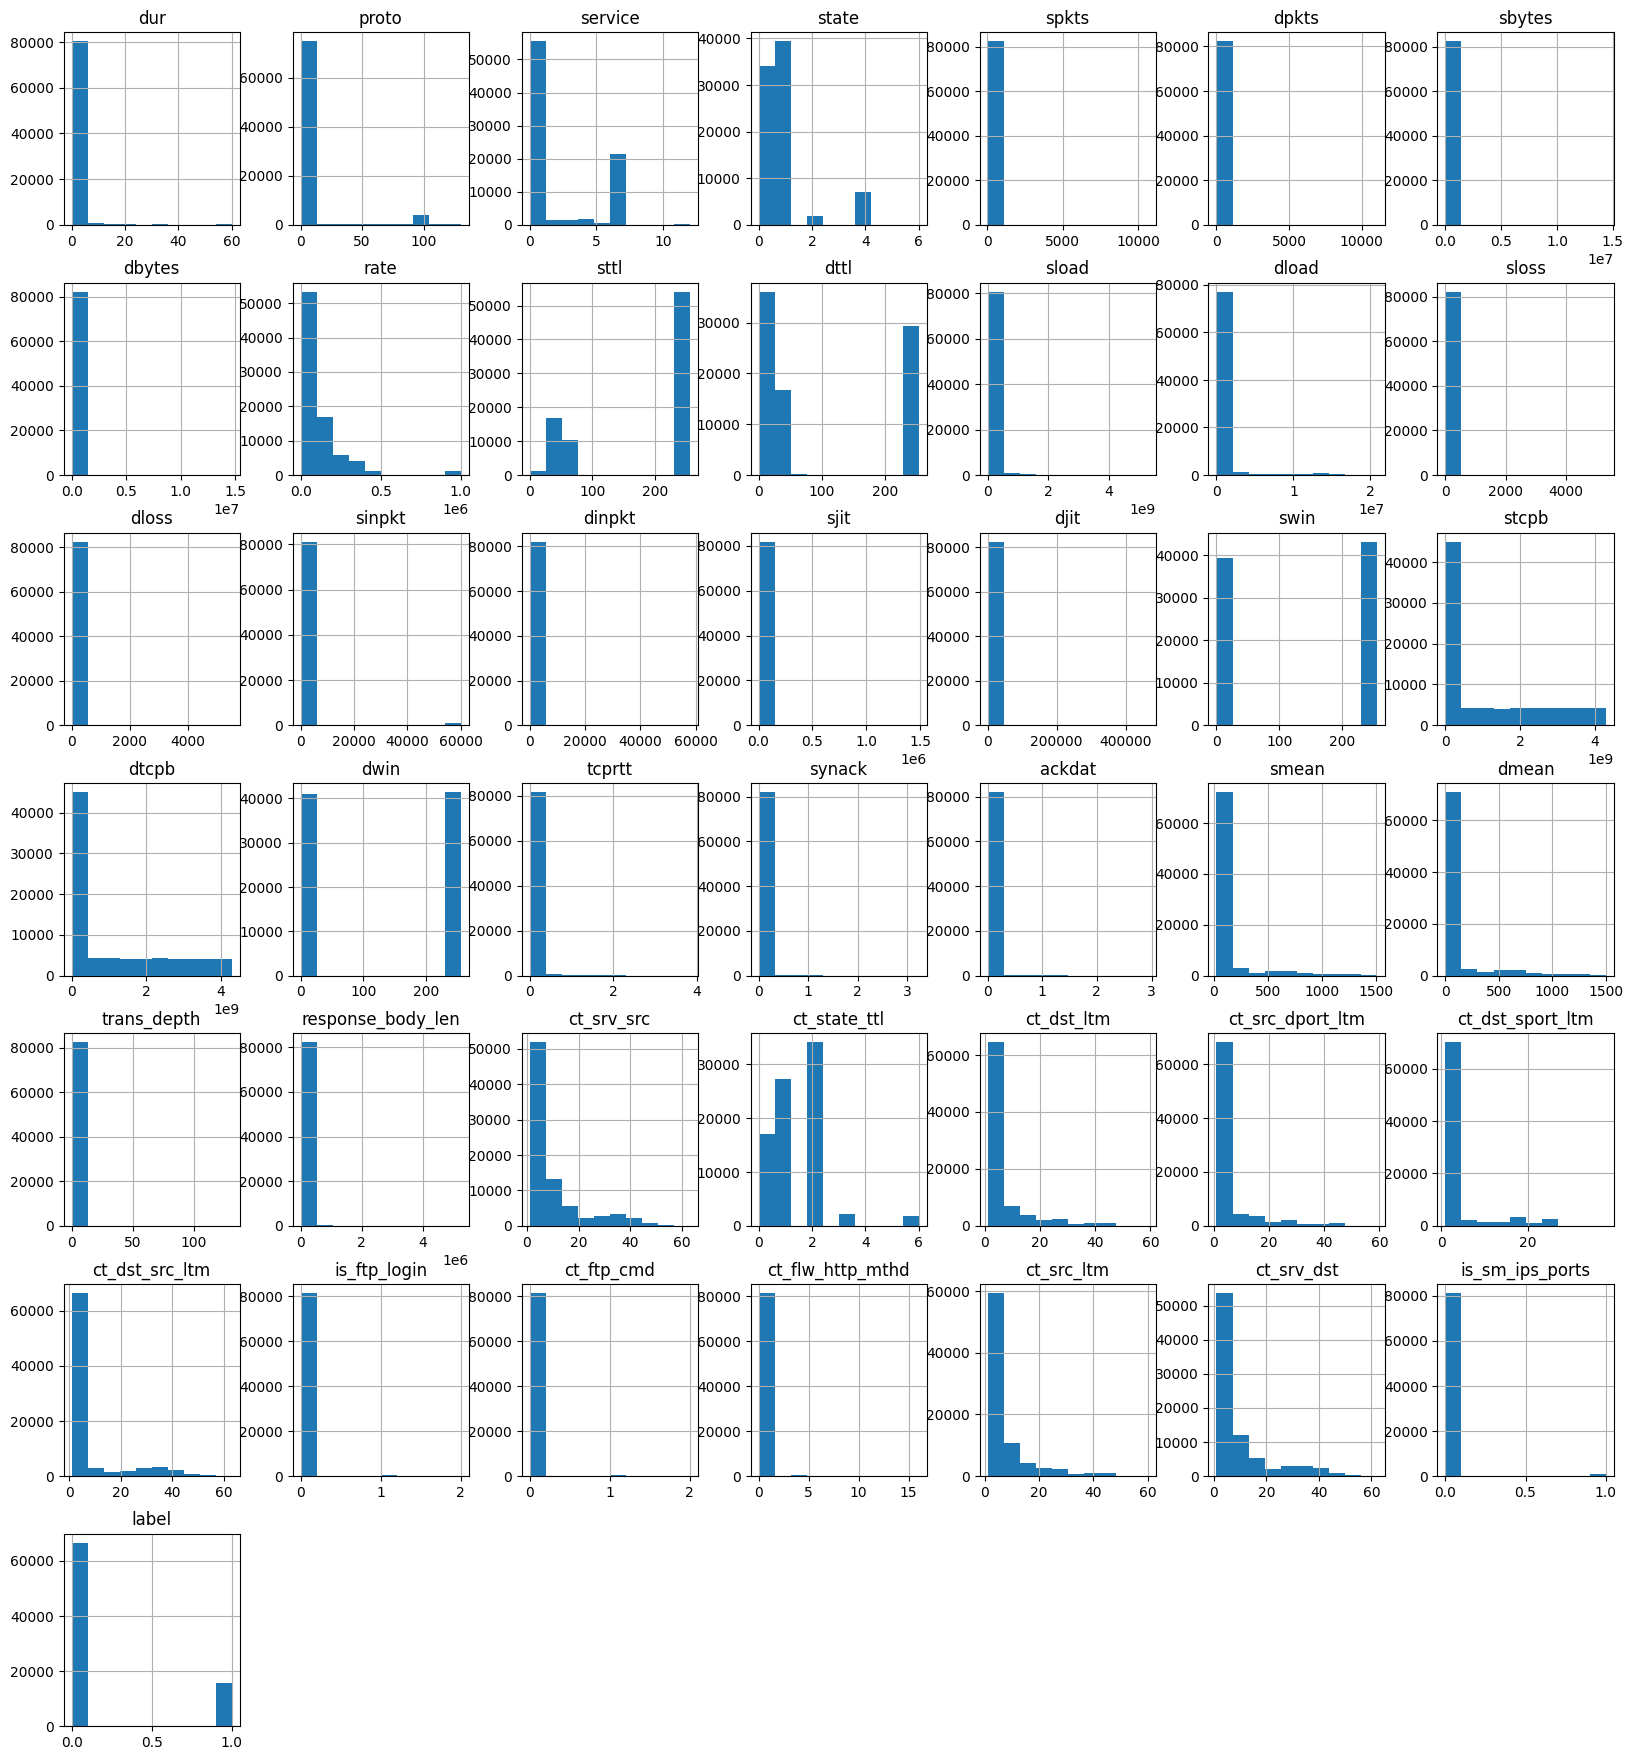

In [6]:
rcParams["figure.figsize"]=(20,22)
train_df.hist()
plt.grid()

In [7]:
spark = SparkSession.builder.appName("CSCI316GP2").getOrCreate()

# Set the random seed
seed = 42
spark.conf.set("spark.seed", seed)

# Convert the preprocessed training data into a Spark DataFrame
spark_train_df = spark.createDataFrame(train_df)
spark_test_df = spark.createDataFrame(test_df)
spark_train_df.show()
spark_test_df.show()

+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+-----+
|   dur|proto|service|state|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|        sload|dload|sloss|dloss|   sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|label|
+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+

In [8]:
# Define the feature columns
feature_columns = spark_train_df.columns[:-1]  # Exclude the "label" column

# Assemble features into a single vector column
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
spark_train_df = feature_assembler.transform(spark_train_df)
spark_test_df = feature_assembler.transform(spark_test_df)

## Basic RF model

In [9]:
# Index the label column
label_indexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(spark_train_df)
label_indexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(spark_test_df)

# Train a RandomForest model
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[label_indexer, rf])

# Train the pipeline
model = pipeline.fit(spark_train_df)

# Make predictions on the test data
predictions = model.transform(spark_test_df)

## Accuracy of Basic RF Model

In [15]:
# Create an evaluator for accuracy
roc_evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_score = roc_evaluator.evaluate(predictions)
print("Area under ROC = %g" % roc_score)

# Create an evaluator for f1 score
pr_evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderPR")
pr_score = pr_evaluator.evaluate(predictions)
print("Area under PR = %g" % pr_score)


Area under ROC = 0.872249
Area under PR = 0.8058


## RF Model with hyperparameter

In [17]:
# Train a RandomForest model
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")

# Define the parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 30, 50]) \
    .addGrid(rf.maxDepth, [5, 8, 10]) \
    .addGrid(rf.impurity, ['gini', 'entropy']) \
    .build()

# Create a CrossValidator instance
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=roc_evaluator,
                          numFolds=3)  # Number of cross-validation folds

# Run cross-validation, and choose the best set of parameters
cv_model = crossval.fit(spark_train_df)

# Train the pipeline
best_model = cv_model.bestModel

# Make predictions on the test data
best_predictions = best_model.transform(spark_test_df)


## Accuracy of RF Model with Hyperparameter

In [18]:
# # Create an evaluator for accuracy
# accuracy_evaluator = BinaryClassificationEvaluator(
#     labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
# best_accuracy = accuracy_evaluator.evaluate(best_predictions)
# print("Accuracy = %g" % best_accuracy)

# # Create an evaluator for f1 score
# f1_evaluator = BinaryClassificationEvaluator(
#     labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
# best_f1_score = f1_evaluator.evaluate(best_predictions)
# print("F1 Score = %g" % best_f1_score)

# # Create an evaluator for precision
# precision_evaluator = BinaryClassificationEvaluator(
#     labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
# best_precision = precision_evaluator.evaluate(best_predictions)
# print("Precision = %g" % best_precision)

# Create an evaluator for accuracy
roc_evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_score = roc_evaluator.evaluate(best_predictions)
print("Area under ROC = %g" % roc_score)

# Create an evaluator for f1 score
pr_evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderPR")
pr_score = pr_evaluator.evaluate(best_predictions)
print("Area under PR = %g" % pr_score)

Area under ROC = 0.872249
Area under PR = 0.8058


In [ ]:
# spark.stop()